In [3]:
# use packages
using CDSAPI
using NCDatasets
using PyPlot
using Dates

In [4]:
# get cartopy -- broken
#=
using PyCall

ccrs = pyimport("cartopy.crs")
feature = pyimport("cartopy.feature")
=#

# pygui(:tk)

# use cartopy to make plots with maps -- downloads fail
# cartopy is broken
# ax = subplot(projection=ccrs.Orthographic(65, 13))
# ax = subplot(projection=ccrs.PlateCarree())
# ax.coastlines()
# ax.add_feature(feature.OCEAN, color="navy")
# ax.add_feature(feature.LAND, color="lightgray")

In [11]:
# download ERA5 data from Copernicus Climate Data Store CDS API

# daystrings(x) = @sprintf("%02d",x)
#=
python format list of days this way:
["{:02d}".format(x) for x in range(1, 31+1)]

    [ '01', '02', '03', '04', '05', '06',
            			      '07', '08', '09', '10', '11', '12',
            			      '13', '14', '15', '16', '17', '18',
            			      '19', '20', '21', '22', '23', '24',
            			      '25', '26', '27', '28', '29', '30',
            			      '31',],
=#

req = CDSAPI.py2ju("""
                         {
                             'product_type': 'reanalysis',
                             'format': 'netcdf',
                             'area': [30, 40, -4, 90],
                             'time': '00:00',
                             'month': [ '05', '06' ],
                             'day':     [ '01', '02', '03', '04', '05', '06',
            			      '07', '08', '09', '10', '11', '12',
            			      '13', '14', '15', '16', '17', '18',
            			      '19', '20', '21', '22', '23', '24',
            			      '25', '26', '27', '28', '29', '30',
            			      '31',],
                             'year': ['2018', '2019', '2020', '2021', '2022'],
                             'pressure_level': [ '850', '1000'],
                             'variable': [ 'divergence', 'fraction_of_cloud_cover', 'geopotential',
                                 'potential_vorticity', 'specific_humidity', 'temperature',
                                 'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity',
                                 'vorticity'],
                         }
                         """)

# download commented out
r = CDSAPI.retrieve( "reanalysis-era5-pressure-levels", req , "era5_as_850_1000.nc" ) # saves data in .nc

LoadError: SystemError: opening file "/Users/sdeszoek/.cdsapirc": No such file or directory

In [6]:
##
# plot data from local copy
ds = NCDatasets.Dataset("era5_as_850_1000.nc")

# test contour vorticity at 850 hPa
# contour(ds["longitude"][:], ds["latitude"][:], ds["vo"][:,:,1,1]')

LoadError: NetCDF error: [31mOpening path era5_as_850_1000.nc: No such file or directory[39m (NetCDF error code: 2)

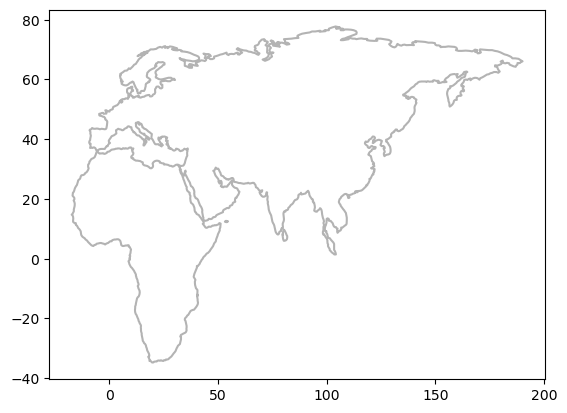

In [114]:
# use coasts.mat to plot land outlines
using MAT
coast = matread("coast.mat")
# separate landmasses into individual index ranges
ibnd = [0; findall(isnan.(coast["lat"][:]) .&& isnan.(coast["long"][:])); length(coast["lat"])+1]
rng = [ ibnd[k]+1 : ibnd[k+1]-1 for k in 1:length(ibnd)-1] # vector of landmass ranges

"filter only index ranges for landmasses in a lon-lat box"
function rng_in_lonlatbox(rng, lon, lat, lon0, lon1, lat0, lat1)
    flt(rng) = any(lon0.<lon[rng].<lon1 .&& lat0.<lat[rng].<lat1)
    return filter(flt, rng)
end

"plot regional coastlines"
function ascoast!(ax, asrng )
    for r in asrng
        ax.plot(coast["long"][r], coast["lat"][r], color=0.7.*[1 1 1])
    end
end

# plot outlines of 4 Arabian Sea landmasses
asrng = rng_in_lonlatbox( rng, coast["long"][:], coast["lat"][:],  40,90 , -4,30 )
ax = subplot(1,1,1)
ascoast!(ax, asrng)

In [39]:
ds

NCDataset: era5_as_850_1000.nc
Group: /

Dimensions
   longitude = 201
   latitude = 137
   level = 2
   time = 305

Variables
  longitude   (201)
    Datatype:    Float32
    Dimensions:  longitude
    Attributes:
     units                = degrees_east
     long_name            = longitude

  latitude   (137)
    Datatype:    Float32
    Dimensions:  latitude
    Attributes:
     units                = degrees_north
     long_name            = latitude

  level   (2)
    Datatype:    Int32
    Dimensions:  level
    Attributes:
     units                = millibars
     long_name            = pressure_level

  time   (305)
    Datatype:    Int32
    Dimensions:  time
    Attributes:
     units                = hours since 1900-01-01 00:00:00.0
     long_name            = time
     calendar             = gregorian

  d   (201 × 137 × 2 × 305)
    Datatype:    Int16
    Dimensions:  longitude × latitude × level × time
    Attributes:
     scale_factor         = 1.6874663189908273e-8
 

In [55]:
var="z"
ds[var].attrib["units"]

"m**2 s**-2"

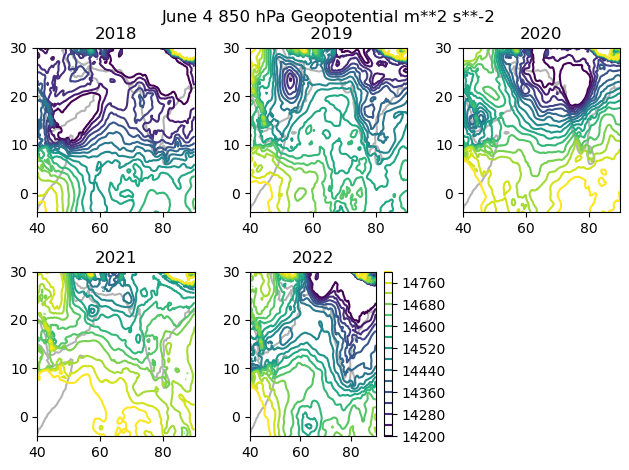

In [113]:
# plot the variable
function plotas!(ax, var, level=1, time=31)
    ct = ax.contour(ds["longitude"][:], ds["latitude"][:], ds[var][:,:,level,time]', 14200:40:14800, vmin=14200, vmax=14800)
    return ct
end


clf()
level = 1
for i = 1:5
    ax = subplot(2,3, i)
    ax.set_xlim(40, 90)
    ax.set_ylim(-4, 30)
    ascoast!( ax, asrng )
    
    year = i-1
    time = year*(31+30)+31+4 # June 4s
    ct = plotas!( ax, "z", level, time )
    i == 5 && colorbar(ct)
    # colorbar(ct)
    if i == 2
        ax.set_title( "$(Dates.format(ds["time"][time], "U d")) $(ds["level"][level]) hPa $(ds[var].attrib["long_name"]) $(ds[var].attrib["units"])\n $(Dates.year(ds["time"][time]))" )
    else
        ax.set_title( "$(Dates.year(ds["time"][time]))" )
    end
end
tight_layout()

In [1]:
clf()
level = 1
for i = 1:5
    ax = subplot(2,3, i)
    ax.set_xlim(40, 90)
    ax.set_ylim(-4, 30)
    ascoast!( ax, asrng )
    
    year = i-1
    time = year*(31+30)+31+4 # June 4s
    ct = plotas!( ax, "vo", level, time )
    i == 5 && colorbar(ct)
    # colorbar(ct)
    if i == 2
        ax.set_title( "$(Dates.format(ds["time"][time], "U d")) $(ds["level"][level]) hPa $(ds[var].attrib["long_name"]) $(ds[var].attrib["units"])\n $(Dates.year(ds["time"][time]))" )
    else
        ax.set_title( "$(Dates.year(ds["time"][time]))" )
    end
end
tight_layout()

LoadError: UndefVarError: clf not defined